In [ ]:
# --- 1.1: Import Necessary Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import Binarizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


In [29]:
# --- 1.2: Load and Clean the Dataset ---
df = pd.read_csv('df_without_stockcode_rfm.csv')  # Adjust path if needed
print(f"Original shape: {df.shape}")

# Drop irrelevant columns
columns_to_drop = ['Quantity', 'InvoiceDate']
df_cleaned = df.drop(columns=columns_to_drop)
print(f"Shape after dropping irrelevant columns: {df_cleaned.shape}")

# --- 1.3: Separate Features (X) and Target (y) ---
y = df_cleaned['IsCancelled']
X = df_cleaned.drop(columns=['IsCancelled'])

# --- 1.4: Create Unseen Test Set and Split Remaining Data ---
n_total = len(X)
unseen_size = 1000

if n_total >= unseen_size:
    X_unseen, X_remaining, y_unseen, y_remaining = train_test_split(
        X, y, test_size=n_total - unseen_size, random_state=42, stratify=y
    )
    print(f"\nUnseen test set shape: {X_unseen.shape}")
    print(f"Unseen test set class distribution:\n{y_unseen.value_counts()}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_remaining, y_remaining, test_size=0.2, random_state=42, stratify=y_remaining
    )
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
else:
    print(f"Not enough samples in the dataset ({n_total}) to create an unseen test set of {unseen_size} records.")

Original shape: (12052, 1556)
Shape after dropping irrelevant columns: (12052, 1554)

Unseen test set shape: (1000, 1553)
Unseen test set class distribution:
IsCancelled
False    533
True     467
Name: count, dtype: int64

Training set shape: (8841, 1553)
Testing set shape: (2211, 1553)


In [30]:
# --- 1.5: Separate TF-IDF and Engineered Features ---
engineered_features = ['UnitPrice', 'QuantityAbsolute', 'TotalAmount', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'Recency', 'Frequency', 'Monetary']
tfidf_columns = [col for col in X_train.columns if col not in engineered_features]

# Split training and testing sets
X_train_tfidf = X_train[tfidf_columns]
X_train_engineered = X_train[engineered_features]
X_test_tfidf = X_test[tfidf_columns]
X_test_engineered = X_test[engineered_features]

print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_train_engineered:", X_train_engineered.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Shape of X_test_engineered:", X_test_engineered.shape)

# Combine for feature selection
X_train_all = pd.concat([X_train_tfidf, X_train_engineered], axis=1)
X_test_all = pd.concat([X_test_tfidf, X_test_engineered], axis=1)

Shape of X_train_tfidf: (8841, 1542)
Shape of X_train_engineered: (8841, 11)
Shape of X_test_tfidf: (2211, 1542)
Shape of X_test_engineered: (2211, 11)


In [31]:
# --- 1.6: Feature Selection with SelectKBest ---
X_train_non_neg = X_train_all.clip(lower=0)
selector = SelectKBest(chi2, k=200)
X_train_selected = selector.fit_transform(X_train_non_neg, y_train)
X_test_selected = selector.transform(X_test_all.clip(lower=0))

selected_features = X_train_all.columns[selector.get_support()].tolist()
print("Number of selected features:", len(selected_features))
print("Sample selected features:", selected_features[:10])

Number of selected features: 200
Sample selected features: ['Country_Australia', 'Country_EIRE', 'Country_France', 'Country_Germany', 'Country_Italy', 'Country_Japan', 'Country_Malta', 'Country_Netherlands', 'Country_Poland', 'Country_USA']


GaussianNB Default - Accuracy: 0.6942559927634554
              precision    recall  f1-score   support

       False       0.67      0.85      0.75      1178
        True       0.75      0.51      0.61      1033

    accuracy                           0.69      2211
   macro avg       0.71      0.68      0.68      2211
weighted avg       0.71      0.69      0.68      2211



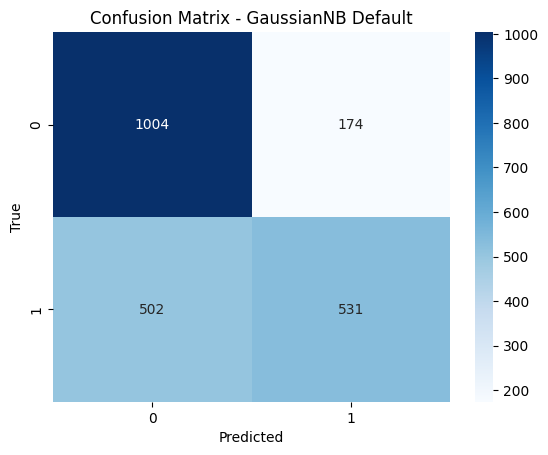

In [32]:
# --- 2.1: Train GaussianNB (Default) ---
gauss_model = GaussianNB()
gauss_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_gauss = gauss_model.predict(X_test_selected)
print("GaussianNB Default - Accuracy:", accuracy_score(y_test, y_pred_gauss))
print(classification_report(y_test, y_pred_gauss))

# Confusion Matrix
cm_gauss = confusion_matrix(y_test, y_pred_gauss)
sns.heatmap(cm_gauss, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GaussianNB Default')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

GaussianNB Tuned - Best params: {'var_smoothing': 1e-07}
Accuracy: 0.6784260515603799
              precision    recall  f1-score   support

       False       0.74      0.61      0.67      1178
        True       0.63      0.75      0.69      1033

    accuracy                           0.68      2211
   macro avg       0.68      0.68      0.68      2211
weighted avg       0.69      0.68      0.68      2211



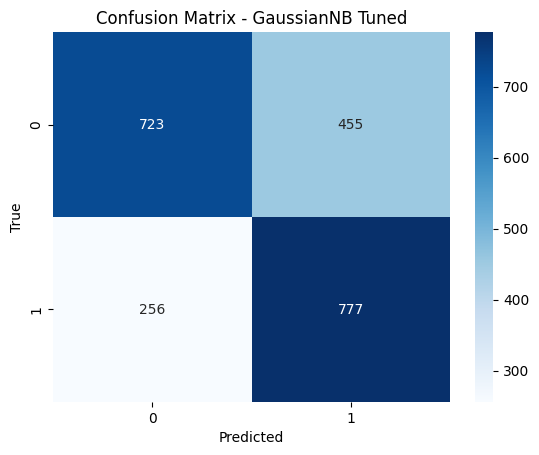

In [33]:
# --- 2.2: Tune GaussianNB with GridSearchCV ---
params = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
grid_gauss = GridSearchCV(GaussianNB(), params, cv=5, scoring='f1')
grid_gauss.fit(X_train_selected, y_train)

# Best model
best_gauss = grid_gauss.best_estimator_
y_pred_gauss_tuned = best_gauss.predict(X_test_selected)
print("GaussianNB Tuned - Best params:", grid_gauss.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gauss_tuned))
print(classification_report(y_test, y_pred_gauss_tuned))

# Confusion Matrix
cm_gauss_tuned = confusion_matrix(y_test, y_pred_gauss_tuned)
sns.heatmap(cm_gauss_tuned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GaussianNB Tuned')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

BernoulliNB - Accuracy: 0.6996834011759385
              precision    recall  f1-score   support

       False       0.72      0.72      0.72      1178
        True       0.68      0.67      0.68      1033

    accuracy                           0.70      2211
   macro avg       0.70      0.70      0.70      2211
weighted avg       0.70      0.70      0.70      2211



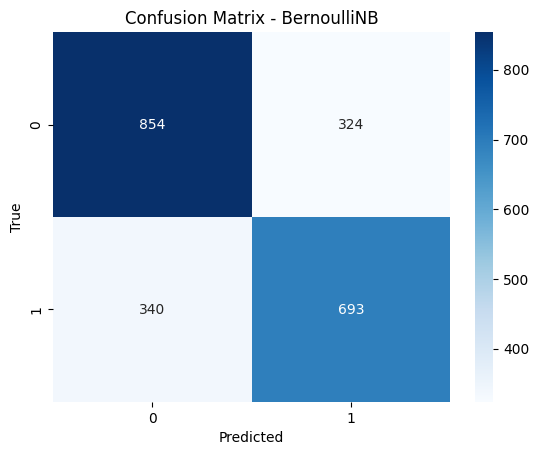

In [34]:
# --- 2.3: Train BernoulliNB with Binarization ---
threshold = X_train_all.select_dtypes(include=['float64', 'int64']).median().median()
binarizer = Binarizer(threshold=threshold)
X_train_binarized = binarizer.fit_transform(X_train_selected)
X_test_binarized = binarizer.transform(X_test_selected)

bern_model = BernoulliNB(alpha=1.0)
bern_model.fit(X_train_binarized, y_train)

# Predict and evaluate
y_pred_bern = bern_model.predict(X_test_binarized)
print("BernoulliNB - Accuracy:", accuracy_score(y_test, y_pred_bern))
print(classification_report(y_test, y_pred_bern))

# Confusion Matrix
cm_bern = confusion_matrix(y_test, y_pred_bern)
sns.heatmap(cm_bern, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BernoulliNB')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
# --- 2.4: Cross-Validation ---
cv_scores_gauss = cross_val_score(best_gauss, X_train_selected, y_train, cv=5, scoring='f1')
print("GaussianNB Tuned CV F1 Scores:", cv_scores_gauss, "Mean:", cv_scores_gauss.mean())

# Compare models
results = pd.DataFrame({
    'Model': ['GaussianNB Default', 'GaussianNB Tuned', 'BernoulliNB'],
    'Accuracy': [accuracy_score(y_test, y_pred_gauss), accuracy_score(y_test, y_pred_gauss_tuned), accuracy_score(y_test, y_pred_bern)],
    'F1 Score': [f1_score(y_test, y_pred_gauss), f1_score(y_test, y_pred_gauss_tuned), f1_score(y_test, y_pred_bern)]
})
print("\nModel Comparison:\n", results)

GaussianNB Tuned CV F1 Scores: [0.70416876 0.69924812 0.63921328 0.67726027 0.63710181] Mean: 0.6713984482053335

Model Comparison:
                 Model  Accuracy  F1 Score
0  GaussianNB Default  0.694256  0.611047
1    GaussianNB Tuned  0.678426  0.686093
2         BernoulliNB  0.699683  0.676098


In [36]:
# --- 2.5: Performance Metrics for GaussianNB Tuned ---
y_train_pred_gauss = best_gauss.predict(X_train_selected)
y_test_pred_gauss = best_gauss.predict(X_test_selected)
y_train_prob_gauss = best_gauss.predict_proba(X_train_selected)[:, 1]
y_test_prob_gauss = best_gauss.predict_proba(X_test_selected)[:, 1]

f1_train_gauss = f1_score(y_train, y_train_pred_gauss)
f1_test_gauss = f1_score(y_test, y_test_pred_gauss)
roc_auc_train_gauss = roc_auc_score(y_train, y_train_prob_gauss)
roc_auc_test_gauss = roc_auc_score(y_test, y_test_prob_gauss)

print("Performance Comparison (Train vs. Test) - GaussianNB Tuned")
print(f"F1 Score (Training): {f1_train_gauss:.4f}")
print(f"F1 Score (Test): {f1_test_gauss:.4f}")
print(f"ROC AUC Score (Training): {roc_auc_train_gauss:.4f}")
print(f"ROC AUC Score (Test): {roc_auc_test_gauss:.4f}")

Performance Comparison (Train vs. Test) - GaussianNB Tuned
F1 Score (Training): 0.6816
F1 Score (Test): 0.6861
ROC AUC Score (Training): 0.7311
ROC AUC Score (Test): 0.7411


In [37]:
# --- 2.6: Performance Metrics for BernoulliNB ---
y_train_pred_bern = bern_model.predict(X_train_binarized)
y_test_pred_bern = bern_model.predict(X_test_binarized)
y_train_prob_bern = bern_model.predict_proba(X_train_binarized)[:, 1]
y_test_prob_bern = bern_model.predict_proba(X_test_binarized)[:, 1]

f1_train_bern = f1_score(y_train, y_train_pred_bern)
f1_test_bern = f1_score(y_test, y_test_pred_bern)
roc_auc_train_bern = roc_auc_score(y_train, y_train_prob_bern)
roc_auc_test_bern = roc_auc_score(y_test, y_test_prob_bern)

print("Performance Comparison (Train vs. Test) - BernoulliNB")
print(f"F1 Score (Training): {f1_train_bern:.4f}")
print(f"F1 Score (Test): {f1_test_bern:.4f}")
print(f"ROC AUC Score (Training): {roc_auc_train_bern:.4f}")
print(f"ROC AUC Score (Test): {roc_auc_test_bern:.4f}")

Performance Comparison (Train vs. Test) - BernoulliNB
F1 Score (Training): 0.6897
F1 Score (Test): 0.6761
ROC AUC Score (Training): 0.7868
ROC AUC Score (Test): 0.7652
